In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet, DenseNet121
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
import os
import cv2

In [22]:
# Function to load preprocessed images
def load_preprocessed_images(data_dir, image_size=(224, 224)):  # Change size to 224x224
    images = []
    labels = []
    class_names = os.listdir(data_dir)  # Assuming each subdirectory is a class

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.isdir(class_dir):  # Skip if not a directory
            continue

        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read {img_path}")
                continue
            
            # Resize the image to the desired size
            image = cv2.resize(image, image_size)
            
            # Normalize the image
            image = image / 255.0
            
            images.append(image)
            labels.append(class_name)  # Store the class name

    return np.array(images), np.array(labels)

# Step 1: Load preprocessed images
data_directory = '../data/processed'  # Update with your path
original_images, y = load_preprocessed_images(data_directory)

In [23]:
# Step 2: Preprocess labels
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_encoded = np.array([label_map[label] for label in y])
y_categorical = to_categorical(y_encoded)

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(original_images, y_categorical, test_size=0.2, random_state=42)

In [24]:
# Step 4: Feature Extraction with MobileNet and DenseNet
def extract_features(model, images):
    # Resize images for the model input
    images_resized = np.array([cv2.resize(image, (224, 224)) for image in images])
    images_preprocessed = preprocess_input(images_resized)  # Preprocess for MobileNet or DenseNet

    # Extract features
    features = model.predict(images_preprocessed)
    return features

# Load the models
mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
densenet_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Extract features
mobilenet_features_train = extract_features(mobilenet_model, X_train)
mobilenet_features_test = extract_features(mobilenet_model, X_test)

densenet_features_train = extract_features(densenet_model, X_train)
densenet_features_test = extract_features(densenet_model, X_test)

106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 304ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 107s 982ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 933ms/step


In [25]:
# Step 5: Apply PCA on the extracted features
n_components = 710
pca_mobilenet = PCA(n_components=n_components)
pca_densenet = PCA(n_components=n_components)

X_train_mobilenet_pca = pca_mobilenet.fit_transform(mobilenet_features_train)
X_test_mobilenet_pca = pca_mobilenet.transform(mobilenet_features_test)

X_train_densenet_pca = pca_densenet.fit_transform(densenet_features_train)
X_test_densenet_pca = pca_densenet.transform(densenet_features_test)

In [26]:
# Step 6: Combine PCA features
X_train_combined = np.concatenate((X_train_mobilenet_pca, X_train_densenet_pca), axis=1)
X_test_combined = np.concatenate((X_test_mobilenet_pca, X_test_densenet_pca), axis=1)

In [27]:
# Step 7: Define the ANN model with more layers
model = Sequential()
model.add(Input(shape=(n_components * 2,)))  # Adjust input shape for combined features
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_map), activation='softmax'))  # Adjust output layer for number of classes

In [28]:
# Step 8: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Step 9: Train the model
history = model.fit(
    X_train_combined,  # Use combined PCA-transformed training data
    y_train,
    validation_data=(X_test_combined, y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3102 - loss: 1.3559 - val_accuracy: 0.6694 - val_loss: 0.9054
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6403 - loss: 0.8620 - val_accuracy: 0.7287 - val_loss: 0.6338
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7172 - loss: 0.6580 - val_accuracy: 0.7915 - val_loss: 0.5625
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7311 - loss: 0.6172 - val_accuracy: 0.7938 - val_loss: 0.5279
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.5312 - val_accuracy: 0.8009 - val_loss: 0.5040
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7995 - loss: 0.5057 - val_accuracy: 0.8365 - val_loss: 0.4709
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8070 - loss: 0.4788 - val_accuracy: 0.8175 - val_loss: 0.4787
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8216 - loss: 0.4496 - val_accuracy: 0.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                      precision    recall  f1-score   support

            cataract       0.85      0.89      0.87       233
diabetic_retinopathy       0.98      0.99      0.99       224
            glaucoma       0.84      0.70      0.76       188
              normal       0.81      0.88      0.85       199

            accuracy                           0.87       844
           macro avg       0.87      0.87      0.87       844
        weighted avg       0.87      0.87      0.87       844

[[208   0  13  12]
 [  1 222   1   0]
 [ 27   1 132  28]
 [  9   3  12 175]]


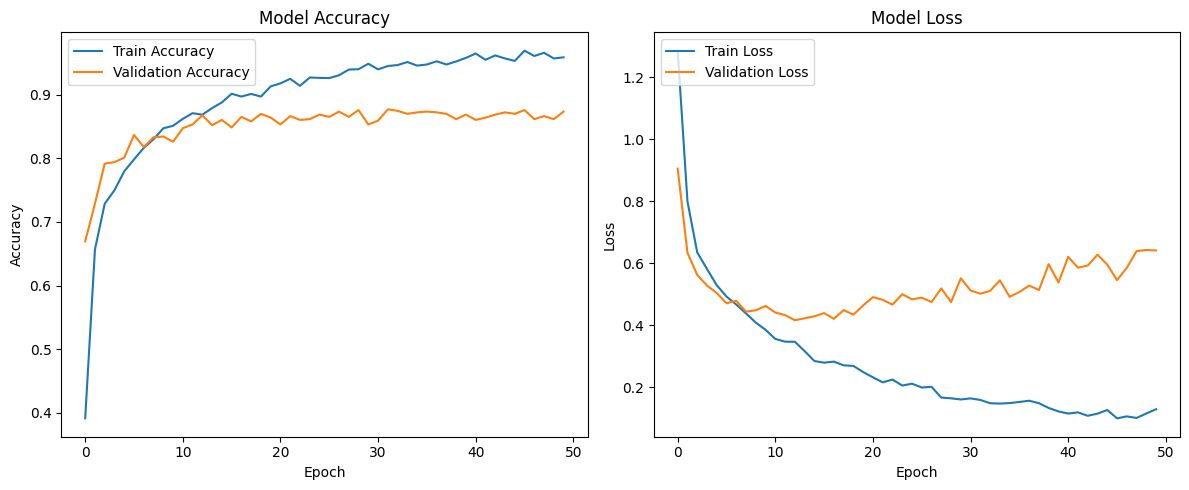

In [30]:
# Step 10: Evaluate the model
y_pred = model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report and confusion matrix
print(classification_report(y_test.argmax(axis=1), y_pred_classes, target_names=label_map.keys()))
print(confusion_matrix(y_test.argmax(axis=1), y_pred_classes))

# Function to plot performance metrics
def plot_performance(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the performance plotting function
plot_performance(history)

In [11]:
#Step 11 : Save the Model
model.save('model.keras')
print("Model saved as model.keras")

Model saved as model.keras
